<a href="https://colab.research.google.com/github/LucasHenrique-dev/RECPAD-2025.2/blob/main/RECPAD_modelo_Linear_Nao_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalar Dependências

In [ ]:
!pip install autorank

  Preparing metadata (setup.py) ... done
  Created wheel for baycomp: filename=baycomp-1.0.3-py3-none-any.whl size=18027 sha256=7e8cd9e7ca414f54d95ec8570fe311dc6b7385e7f09e34374e271e3b8ff9db1f
  Stored in directory: /root/.cache/pip/wheels/ff/39/6a/f87e05ad75b9d87f4eb262a897ec2fe3aab09449d13e3c3b2c
Successfully built baycomp


# Importar Bibliotecas

In [ ]:
import os
import io
import json
import time
import shutil
import zipfile
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from contextlib import redirect_stdout
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from IPython.display import display, HTML
from sklearn.datasets import make_friedman1
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import FitFailedWarning
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from autorank import autorank, plot_stats, create_report, latex_table
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error, explained_variance_score

# Configurações

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)

OUT_DIR = 'resultados_pesquisa'
N_OUTER_FOLDS = 5
N_INNER_ITERATIONS = 40 # RandomizedSearch
STATS_DIR = "statistical_analysis_reports"

TEST_SIZE = 0.3
VISUAL_REPORT_DIR = 'visual_analysis_report'

# Bases de Dados

In [ ]:
# @title ##Carregar Bases de Dados


def download_file(url, dest_path):
    r = requests.get(url)
    r.raise_for_status()
    with open(dest_path, 'wb') as f:
        f.write(r.content)


def load_friedman(n_samples=1000, noise=1.0, random_state=RANDOM_STATE):
    X, y = make_friedman1(n_samples=n_samples, noise=noise, random_state=random_state)
    return pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])]), pd.Series(y, name='target')


def load_concrete():
    # https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls'
    dest = 'Concrete_Data.xls'
    if not os.path.exists(dest):
        download_file(url, dest)
    df = pd.read_excel(dest)
    # Last column is 'Concrete compressive strength' according to dataset
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y


def load_energy():
    # ENB2012_data.xlsx
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
    dest = 'ENB2012_data.xlsx'
    if not os.path.exists(dest):
        download_file(url, dest)
    df = pd.read_excel(dest)
    # Columns: X1..X8, Y1=Heating load, Y2=Cooling load
    # We'll predict Heating load (Y1) by default
    X = df.iloc[:, :-2].copy()
    y = df.iloc[:, -2].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y


def load_airfoil():
    # airfoil_self_noise.dat
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
    dest = 'airfoil_self_noise.dat'
    if not os.path.exists(dest):
        download_file(url, dest)
    # whitespace-separated file with 6 columns (last is target)
    df = pd.read_csv(dest, sep='\t', header=None, comment='!')
    # sometimes sep is whitespace
    if df.shape[1] == 1:
        df = pd.read_csv(dest, sep='\s+', header=None, comment='!')
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y


def load_ccpp():
    # CCPP dataset zip contains 'Folds5x2_pp.xlsx'
    zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip'
    zip_dest = 'CCPP.zip'
    if not os.path.exists(zip_dest):
        download_file(zip_url, zip_dest)
    with zipfile.ZipFile(zip_dest, 'r') as z:
        names = z.namelist()
        # find xlsx file
        xlsx_files = [n for n in names if n.lower().endswith('.xlsx')]
        if not xlsx_files:
            raise RuntimeError('No xlsx found in CCPP.zip')
        xlsx_name = xlsx_files[0]
        with z.open(xlsx_name) as f:
            df = pd.read_excel(f)
    # last column usually 'PE' (net hourly electrical energy output)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    X.columns = [f'x{i}' for i in range(X.shape[1])]
    y.name = 'target'
    return X, y

<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3261529230.py:57: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(dest, sep='\s+', header=None, comment='!')


In [ ]:
# @title ## Tratamento de Dados

In [ ]:
# @title ## Salvar Bases de Dados

DATASETS = {
    'friedman': load_friedman(n_samples=200, noise=1.0),
    'concrete': load_concrete(),
    'energy': load_energy(),
    'friedman2': load_friedman(n_samples=100, noise=1.0),
    'friedman3': load_friedman(n_samples=50, noise=1.0),
    'friedman4': load_friedman(n_samples=30, noise=1.0),
    # 'airfoil': load_airfoil(),
    # 'ccpp': load_ccpp()
}

# Modelos

In [ ]:
# @title ## Modelo Proposto: Linear + Não Linear

class HybridRegressor:
    """
    Estimator that fits a linear regressor first, then fits a non-linear regressor
    on the residuals. Prediction = linear.predict(X) + nonlin.predict(X)
    This is sketched to behave like a scikit-learn estimator (fit, predict).
    """
    def __init__(self, linear, nonlin):
        self.linear = linear
        self.nonlin = nonlin

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # fit linear
        self.linear.fit(X, y)

        # compute residuals on train
        y_lin_pred = self.linear.predict(X)
        resid = y - y_lin_pred

        # fit non-linear on residuals
        self.nonlin.fit(X, resid)

        return self

    def predict(self, X):
        X = np.asarray(X)

        lin_pred = self.linear.predict(X)
        resid_pred = self.nonlin.predict(X)

        return lin_pred + resid_pred

    def get_params(self, deep=True):
        return {"linear": self.linear, "nonlin": self.nonlin}

    def set_params(self, **params):
        for param, value in params.items():
            split = param.split('__', 1)
            if len(split) > 1:
                # Parâmetro aninhado (ex: 'linear__alpha')
                component_name, component_param = split
                if component_name in self.get_params(deep=False):
                    getattr(self, component_name).set_params(**{component_param: value})
            else:
                # Parâmetro do próprio HybridRegressor (ex: 'linear')
                setattr(self, param, value)
        return self

    # MÉTODO EXTRA PARA ANÁLISE DAS CONTRIBUIÇÕES INDIVIDUAIS
    def predict_components(self, X):
        """Retorna a predição final e seus componentes."""
        X = np.asarray(X)

        lin_pred = self.linear.predict(X)
        resid_pred = self.nonlin.predict(X)

        total_pred = lin_pred + resid_pred

        return total_pred, lin_pred, resid_pred

In [ ]:
# @title ## Modelo Linear

class LinearRegressor:
    """
    Estimator that fits a linear regressor. Prediction = linear.predict(X)
    This is sketched to behave like a scikit-learn estimator (fit, predict).
    """
    def __init__(self, linear):
        self.linear = linear

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # fit linear
        self.linear.fit(X, y)

        return self

    def predict(self, X):
        X = np.asarray(X)

        return self.linear.predict(X)

    def get_params(self, deep=True):
        return {"linear": self.linear}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)

        return self

In [ ]:
# @title ## Modelo Não Linear

class NonLinearRegressor:
    """
    Estimator that fits a non-linear regressor. Prediction = nonlin.predict(X)
    This is sketched to behave like a scikit-learn estimator (fit, predict).
    """
    def __init__(self, nonlin):
        self.nonlin = nonlin

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        # fit non-linear
        self.nonlin.fit(X, y)

        return self

    def predict(self, X):
        X = np.asarray(X)

        return self.nonlin.predict(X)

    def get_params(self, deep=True):
        return {"nonlin": self.nonlin}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)

        return self

In [ ]:
# @title ## Modelo Autor 1

In [ ]:
# @title ## Modelo Autor 2

In [ ]:
# @title ## Modelo Autor 3

In [ ]:
# @title ## Definir Parâmetros

PARAM_SPACE_RIDGE_XGB = {
    'linear__alpha': uniform(loc=1e-3, scale=10.0),
    'nonlin__n_estimators': randint(50, 400),
    'nonlin__max_depth': randint(2, 8),
    'nonlin__learning_rate': uniform(loc=0.01, scale=0.3),
    'nonlin__subsample': uniform(loc=0.6, scale=0.4),
    'nonlin__colsample_bytree': uniform(loc=0.5, scale=0.5),
    'nonlin__gamma': uniform(loc=0, scale=0.5)
}

PARAM_SPACE_RIDGE = {
    'alpha': uniform(loc=1e-3, scale=10.0),
}

PARAM_SPACE_XGB = {
    'n_estimators': randint(50, 400),
    'max_depth': randint(2, 8),
    'learning_rate': uniform(loc=0.01, scale=0.3),
    'subsample': uniform(loc=0.6, scale=0.4),
    'colsample_bytree': uniform(loc=0.5, scale=0.5),
    'gamma': uniform(loc=0, scale=0.5)
}

# PARAM_SPACE_EN_RF = {
#     'linear__alpha': uniform(loc=1e-3, scale=5.0),
#     'linear__l1_ratio': uniform(loc=0.0, scale=1.0),
#     'nonlin__n_estimators': randint(50, 400),
#     'nonlin__max_depth': randint(3, 12),
#     'nonlin__max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8]
# }

# PARAM_SPACE_OLS_SVR = {
#     # OLS has no param, but allow an option to use Ridge-like small alpha by swapping class if needed
#     'nonlin__C': uniform(loc=0.1, scale=100.0),
#     'nonlin__gamma': uniform(loc=1e-4, scale=1.0),
#     'nonlin__epsilon': uniform(loc=1e-3, scale=0.5)
# }

In [ ]:
# @title ## Definir Métricas

def evaluate_regression(y_true, y_pred):
    """
    Calcula um conjunto expandido de métricas de regressão
    para analisar diferentes aspectos do desempenho do modelo.
    """
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MaxError': max_error(y_true, y_pred),
        'ExplainedVariance': explained_variance_score(y_true, y_pred)
    }

In [ ]:
# @title ## Salvar Modelos

MODELOS = [
    ('Hibrido_Ridge_XGBoost', HybridRegressor(linear=Ridge(),nonlin=XGBRegressor()), PARAM_SPACE_RIDGE_XGB),
    ('Modelo_Ridge', LinearRegressor(Ridge()), PARAM_SPACE_RIDGE),
    ('Modelo_XGBoost', NonLinearRegressor(XGBRegressor()), PARAM_SPACE_XGB)
    # ('Modelo3')
    # ('Modelo4')
    # ('Modelo5')
    # ('Modelo6')
]

# Teste de Hipótese

In [ ]:
# @title ## Definir Validação Cruzada

def run_nested_cv(X, y, model, param_space, n_outer=5, n_inner_iter=40):
    """
    Executa uma validação cruzada aninhada (Nested Cross-Validation) real.

    Argumentos:
        X, y: Os dados
        model: A instância do estimador scikit-learn, ex: Ridge()
        param_space: O dicionário de distribuições de parâmetros para o RandomizedSearch
        n_outer: Número de folds para o loop de avaliação externo
        n_inner_iter: Número de iterações para o RandomizedSearchCV
    """
    # Garante que X e y sejam arrays numpy para indexação
    if isinstance(X, pd.DataFrame): X = X.values
    if isinstance(y, pd.Series): y = y.values

    outer_cv = KFold(n_splits=n_outer, shuffle=True, random_state=42)

    all_fold_metrics = []

    # Loop Externo (Avaliação)
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        # print(f"  -> Outer Fold {i+1}/{n_outer}...") # Descomente para debug
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Clona o modelo base para garantir que o tuning seja limpo
        model_clone = clone(model)

        # Loop Interno (Tuning de Hiperparâmetros)
        # O CV interno pode ser menor (ex: 3 folds)
        inner_cv_search = RandomizedSearchCV(
            estimator=model_clone,
            param_distributions=param_space,
            n_iter=n_inner_iter,
            cv=3,
            scoring='neg_root_mean_squared_error', # Otimiza para RMSE
            n_jobs=-1,
            random_state=42,
            verbose=0 # Mude para 1 ou 2 para mais detalhes
        )

        # Encontra os melhores parâmetros no conjunto de treino externo
        inner_search_result = inner_cv_search.fit(X_train, y_train)

        # Pega o melhor modelo treinado
        best_model = inner_search_result.best_estimator_

        # Avalia o melhor modelo no conjunto de teste externo
        y_pred = best_model.predict(X_test)

        # Calcula as métricas de desempenho
        fold_metrics = evaluate_regression(y_test, y_pred)
        all_fold_metrics.append(fold_metrics)

    # Compila os resultados de todos os folds externos
    df_folds = pd.DataFrame(all_fold_metrics)
    summary = df_folds.describe().loc[['mean', 'std']]

    return df_folds, summary

In [ ]:
# @title ## Definir Experimento

def run_all_experiments(datasets, experiments, out_dir='results', n_outer=5, n_inner_iter=40):
    """
    Executa a validação cruzada aninhada para todos os modelos
    em todos os datasets e salva os resultados intermediários.

    Retorna listas com os resultados compilados.
    """
    os.makedirs(out_dir, exist_ok=True)
    print(f"Iniciando experimentos... Salvando arquivos intermediários em: {out_dir}")

    all_results_list = []
    summary_results_list = []

    for ds_name, (X, y) in datasets.items():
        print('\n' + '='*60)
        print(f"Dataset: {ds_name} | n={len(y)} | features={X.shape[1]}")
        print('='*60)

        for exp_name, model, param_space in experiments:
            print(f"\nRodando experimento: {exp_name} em {ds_name}")
            start = time.time()

            # Executa o trabalho principal
            df_folds, summary = run_nested_cv(X, y, model, param_space, n_outer=n_outer, n_inner_iter=n_inner_iter)

            elapsed = time.time() - start

            # Salva resultados intermediários (por experimento/dataset)
            fold_path = os.path.join(out_dir, f"{ds_name}__{exp_name}__folds.csv")
            df_folds.to_csv(fold_path, index=False)
            summary_path = os.path.join(out_dir, f"{ds_name}__{exp_name}__summary.csv")
            summary.to_csv(summary_path)

            # Coleta resultados para o resumo final
            # Adiciona todas as métricas ao summary_results_list
            summary_means = summary.loc['mean'].to_dict()
            summary_results_list.append({
                'dataset': ds_name,
                'experiment': exp_name,
                **summary_means # Adiciona todas as métricas (RMSE, MAE, R2, etc.)
            })

            # Coleta resultados para o resumo final
            all_results_list.append({
                'dataset': ds_name,
                'experiment': exp_name,
                'n_samples': len(y),
                'time_s': elapsed,
                'summary_mean_RMSE': summary.loc['mean', 'RMSE'],
                'summary_std_RMSE': summary.loc['std', 'RMSE']
            })

            print(f" -> Concluído em {elapsed:.1f}s | RMSE médio={summary.loc['mean', 'RMSE']:.4f} | R2 médio={summary.loc['mean', 'R2']:.4f}")

    print("\n" + "="*60)
    print("Todos os experimentos foram concluídos.")
    print("="*60)

    return all_results_list, summary_results_list

In [ ]:
# @title ## Definir Teste Estatístico AutoRank

class StatisticalAnalyzer:
    """
    Classe para encapsular a análise estatística usando autorank.
    Recebe o DataFrame de resumo (formato "long") e o pivota
    para o formato "wide" necessário pelo autorank.
    """
    def __init__(self, summary_df, metric_to_test, alpha=0.05, order='ascending'):
        """
        Inicializa o analisador.

        Args:
            summary_df (pd.DataFrame): O DataFrame 'df_summary' com colunas
                                       ['dataset', 'experiment', 'RMSE', 'MAE', ...].
            metric_to_test (str): O nome da coluna de métrica a ser testada (ex: 'RMSE').
            alpha (float): O nível de significância (ex: 0.05).
            order (str): 'ascending' (menor é melhor, ex: RMSE) ou
                         'descending' (maior é melhor, ex: R2).
        """
        if summary_df is None or summary_df.empty:
            raise ValueError("O DataFrame de resumo (summary_df) está vazio ou é None.")

        self.summary_df = summary_df
        self.metric = metric_to_test
        self.alpha = alpha
        self.order = order
        self.df_scores = None # Armazenará o DataFrame pivotado (wide)
        self.result = None    # Armazenará o resultado do autorank

        # Valida a ordem
        if self.order not in ['ascending', 'descending']:
            raise ValueError("O parâmetro 'order' deve ser 'ascending' ou 'descending'.")

    def run_and_analyze(self):
        """
        Executa o pivoting dos dados e a análise estatística do autorank.
        """
        print("\n" + "="*60)
        print(f"Iniciando Análise Estatística para a Métrica: {self.metric.upper()}")
        print(f"(Nível de Significância alpha={self.alpha}, Ordem={self.order})")
        print("="*60)

        # 1. Pivotar os dados para o formato wide:
        #    Linhas = datasets, Colunas = experimentos, Valores = métrica
        try:
            self.df_scores = self.summary_df.pivot(
                index='dataset',
                columns='experiment',
                values=self.metric
            )
        except Exception as e:
            print(f"ERRO: Falha ao pivotar o DataFrame. Verifique as colunas 'dataset', 'experiment' e '{self.metric}'.")
            print(f"Detalhe: {e}")
            return

        # 2. Tratar NaNs (caso um modelo tenha falhado em um dataset)
        if self.df_scores.isnull().values.any():
            print("AVISO: Foram encontrados valores NaN (nulos) no DataFrame pivotado.")
            print(" -> Linhas com NaNs não serão consideradas na análise estatística para esta métrica.")
            # autorank lida bem com NaNs, mas é bom avisar.
            # Alternativa: self.df_scores = self.df_scores.dropna(axis=0)

        # 3. Executar o autorank
        try:
            self.result = autorank(
                self.df_scores,
                alpha=self.alpha,
                verbose=False,
                order=self.order
            )

            if self.result is None:
                print("ERRO: A execução do autorank não retornou resultados.")
                return

            print("-> Análise estatística concluída com sucesso.")

        except Exception as e:
            print(f"ERRO: Falha durante a execução do autorank. Detalhe: {e}")
            self.result = None

    def save_results(self, output_dir='statistics_report'):
        """
        Salva o relatório, gráfico e tabela LaTeX (baseado no seu exemplo).
        """
        if self.result is None or self.df_scores is None:
            print("AVISO: A análise deve ser executada com .run_and_analyze() antes de salvar.")
            return

        # Cria um subdiretório para a métrica específica
        metric_dir = os.path.join(output_dir, self.metric)
        print("\n" + "="*50 + f"\n--- Salvando Relatórios em '{metric_dir}/' ---\n" + "="*50)
        os.makedirs(metric_dir, exist_ok=True)

        # Salva scores, relatório, gráfico e tabela LaTeX
        try:
            self.df_scores.to_csv(os.path.join(metric_dir, "scores_medios.csv"))

            with open(os.path.join(metric_dir, "relatorio_estatistico.txt"), "w", encoding='utf-8') as f:
                with redirect_stdout(f):
                    create_report(self.result)

            # Tenta gerar o gráfico
            plot_stats(self.result)
            plt.savefig(os.path.join(metric_dir, "diagrama_comparativo.png"), dpi=300, bbox_inches='tight')
            plt.close()

            if self.result.pvalue < self.alpha:
                with open(os.path.join(metric_dir, "tabela_autorank.tex"), "w", encoding='utf-8') as f:
                    with redirect_stdout(f):
                        latex_table(self.result)

            print(f"-> Todos os relatórios para '{self.metric}' foram salvos com sucesso.")

        except Exception as e:
            print(f"ERRO: Falha ao salvar um ou mais arquivos de relatório. Detalhe: {e}")

    def display_report(self):
        """
        Exibe o relatório principal no terminal/notebook (baseado no seu exemplo).
        """
        if self.result is None:
            print("AVISO: A análise deve ser executada com .run_and_analyze() antes de exibir o relatório.")
            return

        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)

        print("\n" + "="*50 + f"\n--- Relatório Estatístico (AutoRank): {self.metric.upper()} ---\n" + "="*50)

        print("\n1. Ranks e Scores Médios (por dataset):")
        display(self.result.rankdf.style.format(
            lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x
        ))

        print(f"\n2. Teste Omnibus: {self.result.omnibus.upper()} (p-valor: {self.result.pvalue:.4E})")

        if self.result.pvalue < self.alpha:
            print(f"   -> Conclusão: Rejeitamos a hipótese nula (p < {self.alpha}).")
            print("      Existe uma diferença estatisticamente significativa entre os modelos.")
            if self.result.cd is not None:
                print(f"   -> Diferença Crítica (CD) de Nemenyi: {self.result.cd:.4f}")
            print(f"\n3. Análise Post-Hoc: {self.result.posthoc.upper()}")
            # Exibe a tabela de p-valores do post-hoc, se disponível
            if hasattr(self.result, 'pvalues') and self.result.pvalues is not None:
                display(HTML("<h4>Tabela de p-valores (Post-Hoc)</h4>"))
                display(pd.DataFrame(self.result.pvalues).style.format(
                    lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x
                ))
        else:
            print(f"   -> Conclusão: Não rejeitamos a hipótese nula (p >= {self.alpha}).")
            print("      Não há evidência de diferença estatisticamente significativa entre os modelos.")

        print("\n" + "="*50)
        # Exibe o gráfico de Critical Difference (CD)
        try:
            plot_stats(self.result)
            plt.title(f"Diagrama de Comparação ({self.metric})", pad=20)
            plt.show()
        except Exception as e:
            print(f"AVISO: Falha ao gerar o gráfico de estatísticas. Erro: {e}")

In [ ]:
# @title ## Executar Experimentos

all_results, summary_results = run_all_experiments(
    datasets=DATASETS,
    experiments=MODELOS,
    out_dir=OUT_DIR,
    n_outer=N_OUTER_FOLDS,
    n_inner_iter=N_INNER_ITERATIONS
)

Iniciando experimentos... Salvando arquivos intermediários em: resultados_pesquisa

Dataset: friedman | n=200 | features=10

Rodando experimento: Hibrido_Ridge_XGBoost em friedman
 -> Concluído em 35.4s | RMSE médio=1.8123 | R2 médio=0.8665

Rodando experimento: Modelo_Ridge em friedman
 -> Concluído em 1.8s | RMSE médio=2.7214 | R2 médio=0.7145

Rodando experimento: Modelo_XGBoost em friedman
 -> Concluído em 36.0s | RMSE médio=2.7953 | R2 médio=0.7002

Dataset: concrete | n=1030 | features=8

Rodando experimento: Hibrido_Ridge_XGBoost em concrete
 -> Concluído em 69.3s | RMSE médio=5.1771 | R2 médio=0.9029

Rodando experimento: Modelo_Ridge em concrete
 -> Concluído em 2.6s | RMSE médio=10.5050 | R2 médio=0.6006

Rodando experimento: Modelo_XGBoost em concrete
 -> Concluído em 68.7s | RMSE médio=4.6632 | R2 médio=0.9217

Dataset: energy | n=768 | features=8

Rodando experimento: Hibrido_Ridge_XGBoost em energy
 -> Concluído em 19.9s | RMSE médio=0.4614 | R2 médio=0.9979

Rodando expe

# Resultados

In [ ]:
# @title ## Definir Resultados

def summarize_and_save_results(all_results_list, summary_results_list, out_dir='results'):
    """
    Recebe as listas de resultados, gera os DataFrames finais,
    salva os arquivos de resumo e exibe as tabelas formatadas.
    """
    if not all_results_list or not summary_results_list:
        print("Nenhum resultado para sumarizar.")
        return None, None

    os.makedirs(out_dir, exist_ok=True)
    print("Agregando e salvando resultados finais...")

    # Converte listas para DataFrames
    df_all_overview = pd.DataFrame(all_results_list)
    df_summary_metrics = pd.DataFrame(summary_results_list)

    # Define caminhos finais
    overview_path = os.path.join(out_dir, 'experiments_overview_ALL.csv')
    summary_path = os.path.join(out_dir, 'experiments_summary_ALL.csv')

    # Salva os CSVs finais
    df_all_overview.to_csv(overview_path, index=False)
    df_summary_metrics.to_csv(summary_path, index=False)

    print(f"\nVisão geral salva em: {overview_path}")
    print(f"Métricas resumidas salvas em: {summary_path}")

    # --- Exibição no Colab ---

    # 1. Tabela Pivotada de RMSE (Média)
    display(HTML("<h2>Resultados do Teste de Hipótese (RMSE Médio)</h2>"))
    df_pivot_rmse = df_all_overview.pivot(
        index='dataset',
        columns='experiment',
        values='summary_mean_RMSE'
    ).sort_index()

    # Destaca o menor RMSE (melhor) por linha (dataset)
    display(df_pivot_rmse.style.format("{:.4f}").highlight_min(axis=1, props='background-color: lightgreen; color: black;'))

    # 2. Tabela Pivotada de R² (Média)
    display(HTML("<h2>Resultados do Teste de Hipótese (R² Médio)</h2>"))
    df_pivot_r2 = df_summary_metrics.pivot(
        index='dataset',
        columns='experiment',
        values='R2'
    ).sort_index()

    # Destaca o maior R² (melhor) por linha (dataset)
    display(df_pivot_r2.style.format("{:.4f}").highlight_max(axis=1, props='background-color: lightgreen; color: black;'))

    # 3. Tabela Completa de Métricas
    display(HTML("<h3>Sumário Completo de Métricas (Valores Médios)</h3>"))
    display(df_summary_metrics.sort_values(by=['dataset', 'experiment']).set_index(['dataset', 'experiment']).style.format("{:.4f}"))

    return df_all_overview, df_summary_metrics

In [ ]:
# @title ## Conclusões do Teste de Hipótese

if 'all_results' in locals() and 'summary_results' in locals():
    # Processa e exibe os resultados da execução anterior
    df_overview, df_summary = summarize_and_save_results(
        all_results,
        summary_results,
        out_dir=OUT_DIR
    )
else:
    print("Variáveis de resultado não encontradas.")

# Agora você pode fazer análises adicionais aqui, se desejar.
# Por exemplo, exibir o tempo de execução:
if 'df_overview' in locals() and df_overview is not None:
    display(HTML("<h3>Tempo de Execução (segundos)</h3>"))
    display(df_overview.pivot(
        index='dataset',
        columns='experiment',
        values='time_s'
    ).style.format("{:.2f}s"))

Agregando e salvando resultados finais...

Visão geral salva em: resultados_pesquisa/experiments_overview_ALL.csv
Métricas resumidas salvas em: resultados_pesquisa/experiments_summary_ALL.csv


experiment,Hibrido_Ridge_XGBoost,Modelo_Ridge,Modelo_XGBoost
dataset,,,
concrete,5.1771,10.5050,4.6632
energy,0.4614,3.0159,0.3581
friedman,1.8123,2.7214,2.7953
friedman2,2.1181,2.5861,3.5896
friedman3,2.8560,3.0998,3.6401
friedman4,2.7076,2.9585,4.0237


experiment,Hibrido_Ridge_XGBoost,Modelo_Ridge,Modelo_XGBoost
dataset,,,
concrete,0.9029,0.6006,0.9217
energy,0.9979,0.9096,0.9987
friedman,0.8665,0.7145,0.7002
friedman2,0.8071,0.7174,0.4395
friedman3,0.5920,0.5113,0.3334
friedman4,0.4782,0.4240,0.2388


experiment,Hibrido_Ridge_XGBoost,Modelo_Ridge,Modelo_XGBoost
dataset,,,
concrete,69.32s,2.63s,68.73s
energy,19.90s,1.67s,22.64s
friedman,35.41s,1.84s,36.00s
friedman2,23.63s,1.71s,18.79s
friedman3,19.74s,2.10s,13.55s
friedman4,17.01s,1.57s,11.46s


In [ ]:
# @title ## Executar AutoRank

if 'df_summary' in locals() and df_summary is not None:
    print(f"Iniciando análise estatística. Resultados serão salvos em '{STATS_DIR}/'")

    # --- Análise 1: RMSE (Quanto menor, melhor) ---
    analyzer_rmse = StatisticalAnalyzer(
        summary_df=df_summary,
        metric_to_test='RMSE',
        alpha=0.05,
        order='ascending' # 'ascending' pois RMSE menor é melhor
    )
    analyzer_rmse.run_and_analyze()
    analyzer_rmse.display_report()
    analyzer_rmse.save_results(output_dir=STATS_DIR)

    # --- Análise 2: R2 (Quanto maior, melhor) ---
    analyzer_r2 = StatisticalAnalyzer(
        summary_df=df_summary,
        metric_to_test='R2',
        alpha=0.05,
        order='descending' # 'descending' pois R2 maior é melhor
    )
    analyzer_r2.run_and_analyze()
    analyzer_r2.display_report()
    analyzer_r2.save_results(output_dir=STATS_DIR)

else:
    print("ERRO: DataFrame 'df_summary' não encontrado.")

Iniciando análise estatística. Resultados serão salvos em 'statistical_analysis_reports/'

Iniciando Análise Estatística para a Métrica: RMSE
(Nível de Significância alpha=0.05, Ordem=ascending)
                       meanrank    median       mad  ci_lower   ci_upper effect_size   magnitude effect_size_above magnitude_above
Hibrido_Ridge_XGBoost  1.333333  2.412867   0.52185  0.461424   5.177077         0.0  negligible               0.0      negligible
Modelo_Ridge           2.333333  2.987159  0.189234  2.586148  10.505041   -0.986851       large         -0.986851           large
Modelo_XGBoost         2.333333  3.614882   0.61419  0.358073   4.663179   -1.422631       large         -0.931673           large
-> Análise estatística concluída com sucesso.

--- Relatório Estatístico (AutoRank): RMSE ---

1. Ranks e Scores Médios (por dataset):


,meanrank,median,mad,ci_lower,ci_upper,effect_size,magnitude,effect_size_above,magnitude_above
Hibrido_Ridge_XGBoost,1.333,2.413,0.522,0.461,5.177,0.000,negligible,0.000,negligible
Modelo_Ridge,2.333,2.987,0.189,2.586,10.505,-0.987,large,-0.987,large
Modelo_XGBoost,2.333,3.615,0.614,0.358,4.663,-1.423,large,-0.932,large



2. Teste Omnibus: FRIEDMAN (p-valor: 1.3534E-01)
   -> Conclusão: Não rejeitamos a hipótese nula (p >= 0.05).
      Não há evidência de diferença estatisticamente significativa entre os modelos.

AVISO: Falha ao gerar o gráfico de estatísticas. Erro: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

--- Salvando Relatórios em 'statistical_analysis_reports/RMSE/' ---
ERRO: Falha ao salvar um ou mais arquivos de relatório. Detalhe: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

Iniciando Análise Estatística para a Métrica: R2
(Nível de Significância alpha=0.05, Ordem=descending)
                       meanrank      mean       std ci_lower ci_upper effect_size   magnitude effect_size_above magnitude_above
Modelo_Ridge           2.3

,meanrank,mean,std,ci_lower,ci_upper,effect_size,magnitude,effect_size_above,magnitude_above
Modelo_Ridge,2.333,0.646,0.172,0.468,0.824,0.000,negligible,0.000,negligible
Modelo_XGBoost,2.333,0.605,0.316,0.427,0.783,0.160,negligible,0.160,negligible
Hibrido_Ridge_XGBoost,1.333,0.774,0.199,0.596,0.952,-0.688,medium,-0.639,medium



2. Teste Omnibus: ANOVA (p-valor: 7.1978E-02)
   -> Conclusão: Não rejeitamos a hipótese nula (p >= 0.05).
      Não há evidência de diferença estatisticamente significativa entre os modelos.

AVISO: Falha ao gerar o gráfico de estatísticas. Erro: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

--- Salvando Relatórios em 'statistical_analysis_reports/R2/' ---
ERRO: Falha ao salvar um ou mais arquivos de relatório. Detalhe: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.


In [ ]:
# @title ## Análise Gráfica

# 1. Carregar os dados
X, y = load_friedman()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# 2. Definir os modelos para comparação
models = {
    "Linear (Ridge)": Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=RANDOM_STATE))
    ]),
    "Non-Linear (XGBoost)": XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, verbosity=0),
    "Hybrid (Ridge + XGBoost)": make_ridge_xgb()
}

# 3. Treinar modelos e coletar resultados
results = {}
predictions = {}
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    results[name] = evaluate(y_test, y_pred)

# Transformar resultados em um DataFrame para facilitar a plotagem
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
print("\n--- Resultados ---")
print(results_df)

# ==============================================================================
# PLOTAGEM DOS GRÁFICOS
# ==============================================================================

# Gráfico 1: Comparação de Métricas (R² e RMSE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Comparação de Desempenho dos Modelos', fontsize=16)

# R² (quanto maior, melhor)
sns.barplot(x='Model', y='R2', data=results_df, ax=axes[0], palette='viridis')
axes[0].set_title('Coeficiente de Determinação (R²)')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=15)

# RMSE (quanto menor, melhor)
sns.barplot(x='Model', y='RMSE', data=results_df, ax=axes[1], palette='plasma')
axes[1].set_title('Raiz do Erro Quadrático Médio (RMSE)')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Gráfico 2: Real vs. Predito
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Valores Reais vs. Valores Preditos', fontsize=16)
max_val = max(y_test.max(), max(p.max() for p in predictions.values()))
min_val = min(y_test.min(), min(p.min() for p in predictions.values()))

for i, (name, y_pred) in enumerate(predictions.items()):
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[i], alpha=0.6, s=50, label=f'R²: {results[name]["R2"]:.3f}')
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) # Linha de referência (y=x)
    axes[i].set_title(name)
    axes[i].set_xlabel('Valores Reais')
    axes[i].set_ylabel('Valores Preditos')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Gráfico 3: Análise de Resíduos
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Análise de Resíduos (Preditos vs. Erros)', fontsize=16)

for i, (name, y_pred) in enumerate(predictions.items()):
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[i], alpha=0.6, s=50)
    axes[i].axhline(y=0, color='r', linestyle='--') # Linha de erro zero
    axes[i].set_title(name)
    axes[i].set_xlabel('Valores Preditos')
    axes[i].set_ylabel('Resíduos (Real - Predito)')
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# @title ## Definir Comparações Gráficas

def plot_metric_comparison(results_df, ds_name, output_dir):
    """Gráfico 1: Comparação de Métricas (R² e RMSE)."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Comparação de Desempenho - Dataset: {ds_name}', fontsize=16)

    # R² (quanto maior, melhor)
    sns.barplot(x='Model', y='R2', data=results_df, ax=axes[0], palette='viridis')
    axes[0].set_title('Coeficiente de Determinação (R²)')
    axes[0].set_ylabel('R² Score')
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', rotation=15)

    # RMSE (quanto menor, melhor)
    sns.barplot(x='Model', y='RMSE', data=results_df, ax=axes[1], palette='plasma')
    axes[1].set_title('Raiz do Erro Quadrático Médio (RMSE)')
    axes[1].set_ylabel('RMSE')
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', rotation=15)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Salvar figura
    save_path = os.path.join(output_dir, f"{ds_name}__01_metric_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico de comparação de métricas salvo em: {save_path}")

def plot_real_vs_predicted(predictions, y_test, results, ds_name, output_dir):
    """Gráfico 2: Real vs. Predito."""
    num_models = len(predictions)
    fig, axes = plt.subplots(1, num_models, figsize=(8 * num_models, 7), sharey=True, sharex=True)
    if num_models == 1: axes = [axes] # Garante que axes seja iterável

    fig.suptitle(f'Valores Reais vs. Preditos - Dataset: {ds_name}', fontsize=16)

    # Encontra limites globais para os eixos
    all_preds = np.concatenate([p for p in predictions.values()])
    max_val = max(y_test.max(), all_preds.max())
    min_val = min(y_test.min(), all_preds.min())
    padding = (max_val - min_val) * 0.05 # Adiciona um padding

    for i, (name, y_pred) in enumerate(predictions.items()):
        r2 = results[name]["R2"]
        sns.scatterplot(x=y_test, y=y_pred, ax=axes[i], alpha=0.6, s=50, label=f'R²: {r2:.3f}')
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) # Linha de referência (y=x)
        axes[i].set_title(name)
        axes[i].set_xlabel('Valores Reais')
        axes[i].set_ylabel('Valores Preditos' if i == 0 else '')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_xlim(min_val - padding, max_val + padding)
        axes[i].set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Salvar figura
    save_path = os.path.join(output_dir, f"{ds_name}__02_real_vs_predicted.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico Real vs. Predito salvo em: {save_path}")

def plot_residual_analysis(predictions, y_test, ds_name, output_dir):
    """Gráfico 3: Análise de Resíduos."""
    num_models = len(predictions)
    fig, axes = plt.subplots(1, num_models, figsize=(8 * num_models, 7), sharey=True)
    if num_models == 1: axes = [axes] # Garante que axes seja iterável

    fig.suptitle(f'Análise de Resíduos (Preditos vs. Erros) - Dataset: {ds_name}', fontsize=16)

    for i, (name, y_pred) in enumerate(predictions.items()):
        residuals = y_test - y_pred
        sns.scatterplot(x=y_pred, y=residuals, ax=axes[i], alpha=0.6, s=50)
        axes[i].axhline(y=0, color='r', linestyle='--') # Linha de erro zero
        axes[i].set_title(name)
        axes[i].set_xlabel('Valores Preditos')
        axes[i].set_ylabel('Resíduos (Real - Predito)' if i == 0 else '')
        axes[i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Salvar figura
    save_path = os.path.join(output_dir, f"{ds_name}__03_residual_analysis.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico de Resíduos salvo em: {save_path}")

Iniciando Estudo de Caso Visual...
Carregando dataset: 'concrete'

--- Treinando Modelos para Estudo de Caso ---
Treinando Hibrido_Ridge_XGBoost...
Treinando Modelo_Ridge...
Treinando Modelo_XGBoost...

--- Resultados do Estudo de Caso ---


,Model,RMSE,MAE,MedAE,R2,MaxError,ExplainedVariance
0,Hibrido_Ridge_XGBoost,4.150516,2.776287,1.869502,0.936333,19.676441,0.938191
1,Modelo_Ridge,10.476441,8.298627,6.655377,0.594366,34.583196,0.594479
2,Modelo_XGBoost,4.780312,3.141221,2.107536,0.915546,22.789216,0.916948



--- Gerando Gráficos ---


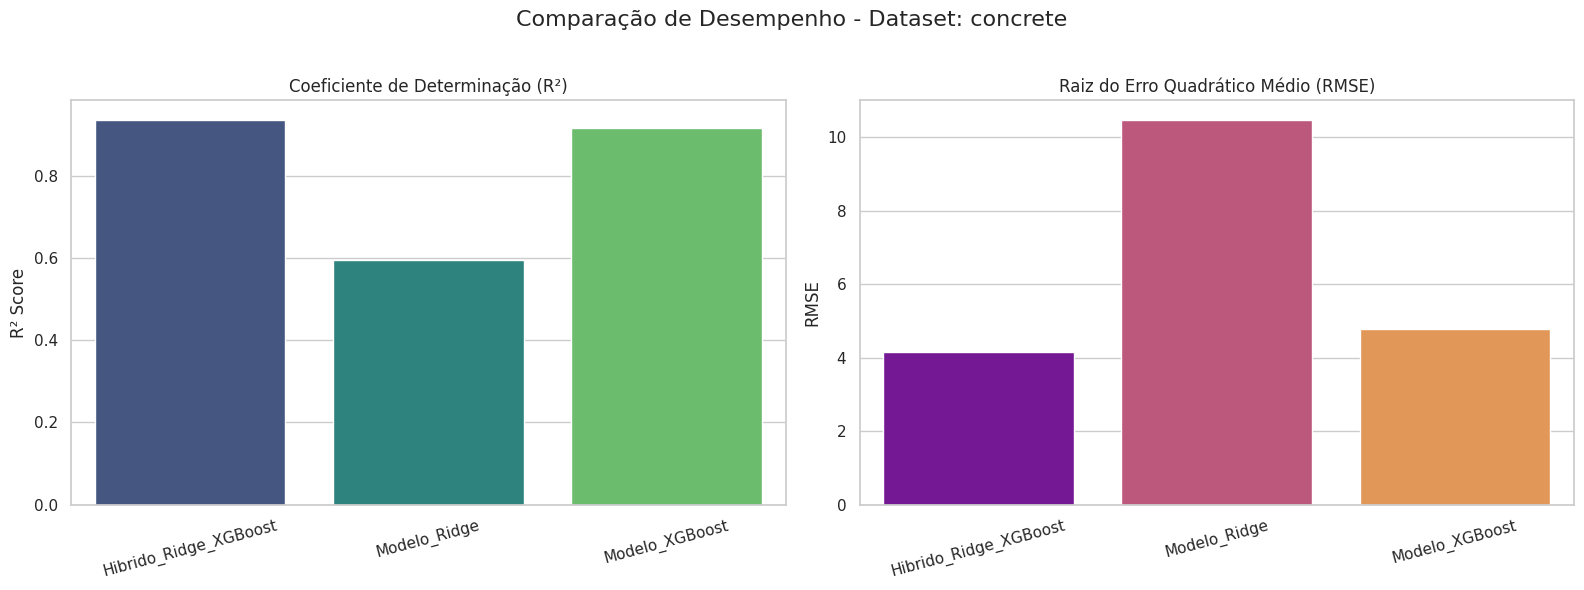

Gráfico de comparação de métricas salvo em: visual_analysis_report/concrete__01_metric_comparison.png


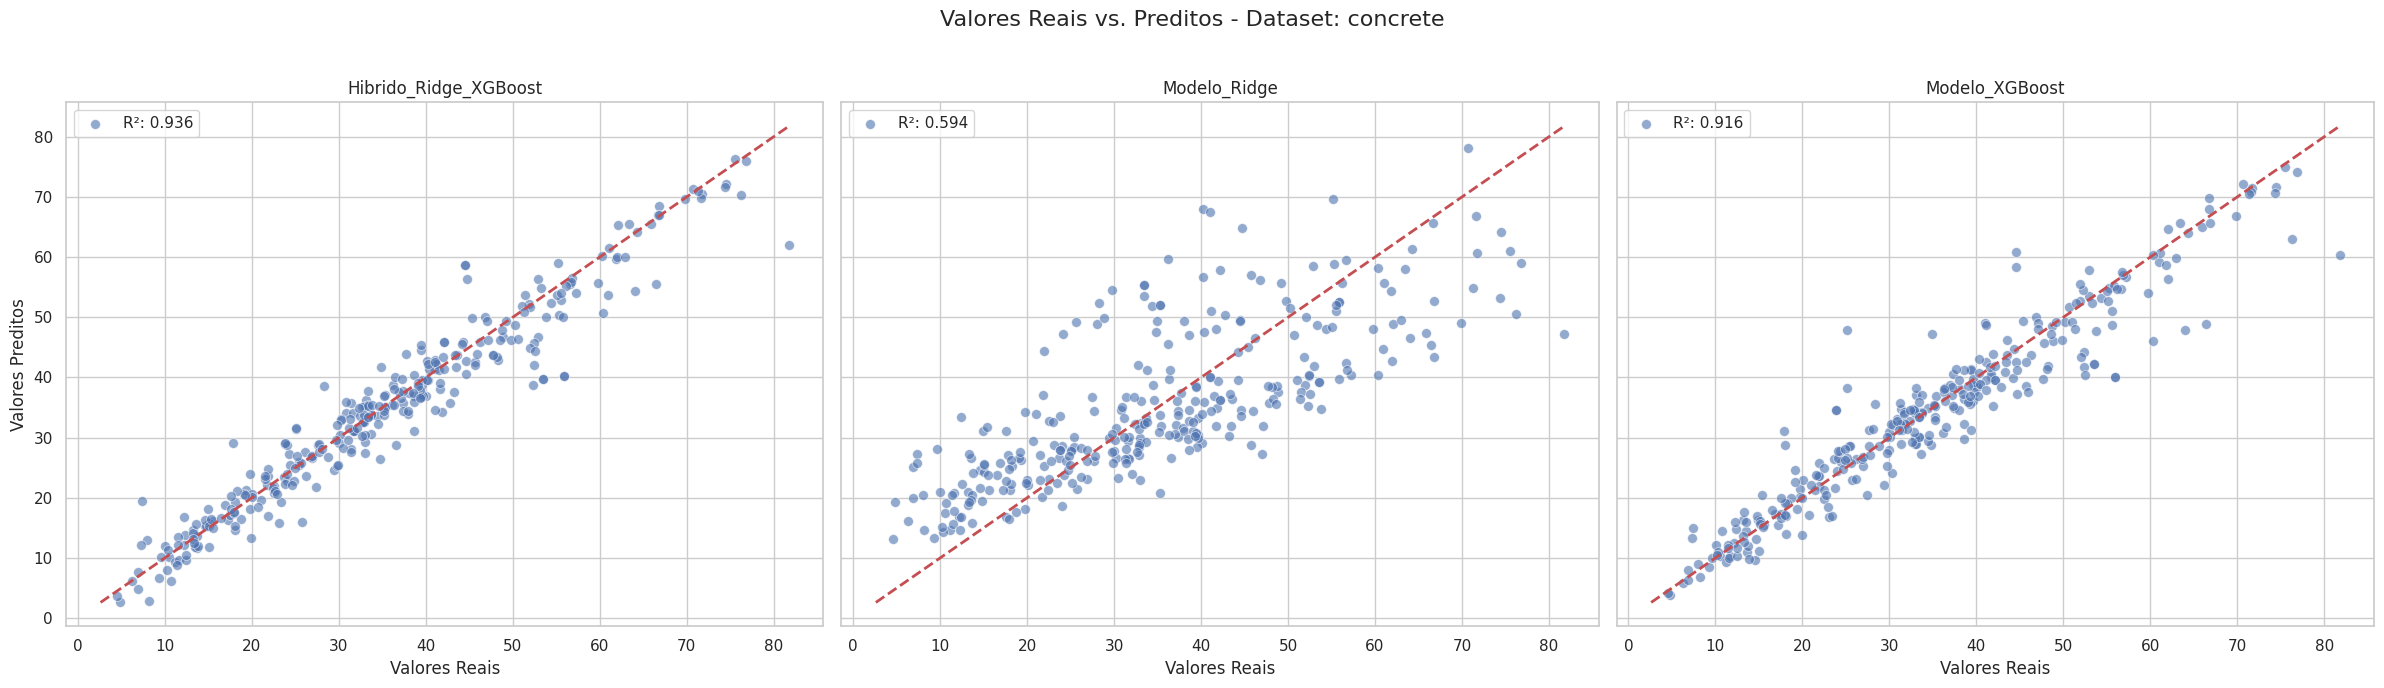

Gráfico Real vs. Predito salvo em: visual_analysis_report/concrete__02_real_vs_predicted.png


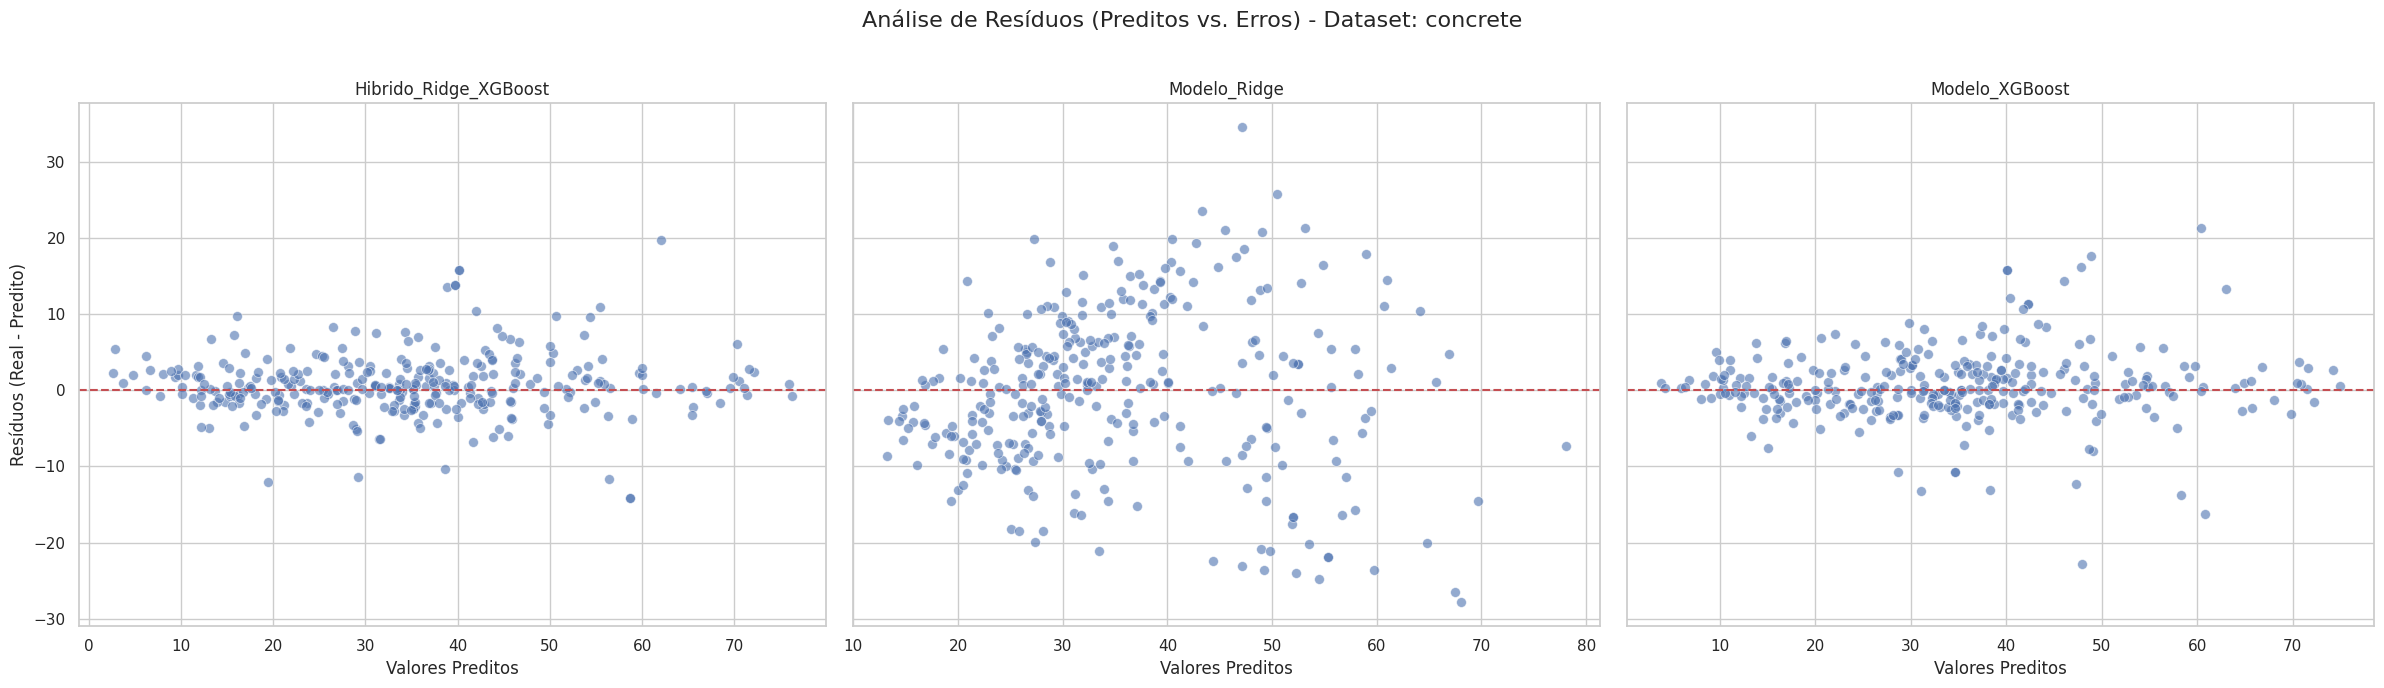

Gráfico de Resíduos salvo em: visual_analysis_report/concrete__03_residual_analysis.png

--- Análise Gráfica Concluída ---


In [ ]:
# @title ## Exibir Gráficos

print("Iniciando Estudo de Caso Visual...")
os.makedirs(VISUAL_REPORT_DIR, exist_ok=True)

DATASET_PARA_PLOTAR = 'concrete'

# 1. Carregar os dados
print(f"Carregando dataset: '{DATASET_PARA_PLOTAR}'")
if DATASET_PARA_PLOTAR == 'friedman':
    X, y = load_friedman(n_samples=1000, noise=1.0)
elif DATASET_PARA_PLOTAR == 'concrete':
    X, y = load_concrete()
elif DATASET_PARA_PLOTAR == 'energy':
    X, y = load_energy()
else:
    raise ValueError(f"Dataset '{DATASET_PARA_PLOTAR}' não reconhecido.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 2. Definir os modelos para comparação
models_to_plot = {}
for name, model_instance, _ in MODELOS:
    models_to_plot[name] = clone(model_instance)

# 3. Treinar modelos e coletar resultados
results = {}
predictions = {}
print("\n--- Treinando Modelos para Estudo de Caso ---")
for name, model in models_to_plot.items():
    print(f"Treinando {name}...")
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        results[name] = evaluate_regression(y_test, y_pred)
    except Exception as e:
        print(f"ERRO ao treinar o modelo {name}: {e}")

# Transformar resultados em um DataFrame para facilitar a plotagem
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
print("\n--- Resultados do Estudo de Caso ---")
display(results_df)

# ==============================================================================
# 4. PLOTAGEM DOS GRÁFICOS (Chamando as funções da Célula 1)
# ==============================================================================

if not results_df.empty:
    print("\n--- Gerando Gráficos ---")

    # Gráfico 1: Comparação de Métricas
    plot_metric_comparison(results_df, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR)

    # Gráfico 2: Real vs. Predito
    plot_real_vs_predicted(predictions, y_test, results, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR)

    # Gráfico 3: Análise de Resíduos
    plot_residual_analysis(predictions, y_test, DATASET_PARA_PLOTAR, VISUAL_REPORT_DIR)

    print("\n--- Análise Gráfica Concluída ---")
else:
    print("\nNenhum resultado para plotar. Verifique os erros de treinamento.")